In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  train_test_split
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier,NearestCentroid
from sklearn.metrics import mean_squared_error, roc_curve, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
sns.set()

Загрузка данные сета.

In [111]:
glasses = pd.read_csv('glass.data',names=["Id","Ri","Na","Mg","Al","Si","K","Ca","Ba","Fe","Class"])
#Смотрим основные параметры.

Оцениваем что в дата-сете есть, и с чем прийдется иметь дело.

In [112]:
glasses.head(100)

,Id,Ri,Na,Mg,Al,Si,K,Ca,Ba,Fe,Class
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.00,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.00,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.00,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.00,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...
95,96,1.51860,13.36,3.43,1.43,72.26,0.51,8.60,0.00,0.00,2
96,97,1.51841,13.02,3.62,1.06,72.34,0.64,9.13,0.00,0.15,2
97,98,1.51743,12.20,3.25,1.16,73.55,0.62,8.90,0.00,0.24,2
98,99,1.51689,12.67,2.88,1.71,73.21,0.73,8.54,0.00,0.00,2


In [113]:
glasses.drop(columns=["Id"],inplace=True)

Cмотрим насколько однородны данные и сколько пропущенных элементов в тех или иных столбцах.

In [114]:
glasses.count()

Ri       214
Na       214
Mg       214
Al       214
Si       214
K        214
Ca       214
Ba       214
Fe       214
Class    214
dtype: int64

В процентном соотношении.

In [ ]:
for col in glasses.columns:
    pct_missing = np.mean(glasses[col].isnull())
    print(f'{col} - {round(pct_missing * 100, 5)}     min: {glasses[col].min()}     max:{glasses[col].max()}')

Общие зависимости и распределение данных.

In [115]:
sns.pairplot(glasses,hue="Class");

In [118]:
glasses.describe()

,Ri,Na,Mg,Al,Si,K,Ca,Ba,Fe,Class
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


Создаём карту корреляций.

<AxesSubplot: >

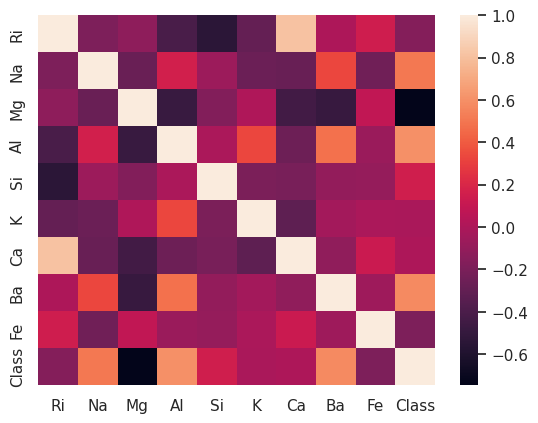

In [119]:
corr = glasses.corr()
sns.heatmap(corr)

Видно что столбцы Ca, K имеют корреляцию с другими параметрами но не с таргетом, можем их откинуть. Так же видно что корреляцию на таргет имеют столбцы Na, Al, Ba.

In [120]:
glasses.drop(columns=["Ca","K"],inplace=True)

Выделяем столбец таргера

In [121]:
target = glasses["Class"]
glasses.drop(columns=["Class"], inplace=True)

,Ri,Na,Mg,Al,Si,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.00,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.00,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.00,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.00,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.00,0.0
...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,1.06,0.0
210,1.51685,14.92,0.00,1.99,73.06,1.59,0.0
211,1.52065,14.36,0.00,2.02,73.42,1.64,0.0
212,1.51651,14.38,0.00,1.94,73.61,1.57,0.0


Скалер и разделение даасета на train/test.

In [122]:
scaler = preprocessing.MinMaxScaler()
glasses = scaler.fit_transform(glasses)

In [123]:
datasets= {"train":{},"test":{}}
datasets["train"]["data"], datasets["test"]["data"], datasets["train"]["target"], datasets["test"]["target"] = train_test_split(glasses, target, train_size=0.70093457944,stratify=target, shuffle=True)
print(datasets["train"]["data"].shape)

(150, 8)


Смотрим что-бы все классы были распределены равномерно.

In [124]:
datasets["train"]["target"].value_counts()

2    53
1    49
7    21
3    12
5     9
6     6
Name: Class, dtype: int64

In [125]:
datasets["test"]["target"].value_counts()

2    23
1    21
7     8
3     5
5     4
6     3
Name: Class, dtype: int64

Тренеруем базовые модели.

In [126]:
knn = KNeighborsClassifier()
knn.fit(datasets["train"]["data"],datasets["train"]["target"])
rnc = RadiusNeighborsClassifier(radius=3) #smallest possible radius
rnc.fit(datasets["train"]["data"],datasets["train"]["target"])
nearc = NearestCentroid()
nearc.fit(datasets["train"]["data"],datasets["train"]["target"])

NearestCentroid()

Сравним какая модель лучше себя покажет на валидационных данных, вычислив среднеквадратическую ошибку для каждой.

In [127]:
predictions = knn.predict(datasets["test"]["data"])
mse = mean_squared_error(datasets["test"]["target"], predictions)
print("MSE for knn: {}".format(mse))

predictions = rnc.predict(datasets["test"]["data"])
mse = mean_squared_error(datasets["test"]["target"], predictions)
print("MSE for rnc: {}".format(mse))

predictions = nearc.predict(datasets["test"]["data"])
mse = mean_squared_error(datasets["test"]["target"], predictions)
print("MSE for nearc: {}".format(mse))

MSE for knn: 0.359375
MSE for rnc: 4.84375
MSE for nearc: 0.5625


Как видно лучше всего справляется модель KNeighborsClassifier, её и возьмём за основу.

In [128]:
parameters = {"n_neighbors":(3,4,5,6,7,8,9),"weights":("uniform","distance"),"algorithm":("ball_tree","kd_tree","brute"),"p":[1,2]}
clf = GridSearchCV(KNeighborsClassifier(), parameters)
clf.fit(datasets["train"]["data"],datasets["train"]["target"])

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ('ball_tree', 'kd_tree', 'brute'),
                         'n_neighbors': (3, 4, 5, 6, 7, 8, 9), 'p': [1, 2],
                         'weights': ('uniform', 'distance')})

Получаем такой результат

In [129]:
prediction = clf.predict(datasets["test"]["data"])
mse = mean_squared_error(datasets["test"]["target"], prediction)
print("MSE: {}".format(mse))

MSE: 0.21875


Считаем метрики.

In [130]:
accuracy = metrics.accuracy_score(datasets["test"]["target"], prediction)
balanced_accuracy = metrics.balanced_accuracy_score(datasets["test"]["target"], prediction)
precision = metrics.precision_score(datasets["test"]["target"], prediction, average='weighted')
recall = metrics.recall_score(datasets["test"]["target"], prediction, average='weighted')

print("Presicion fo I_MF_model: ",round(precision,2))
print("Recall fo I_MF_model: ",round(precision,2))
print("Accurracy fo I_MF_model: ",round(accuracy,2))
print("Balanced accurracy fo I_MF_model: ",round(balanced_accuracy,2))

Presicion fo I_MF_model:  0.92
Recall fo I_MF_model:  0.92
Accurracy fo I_MF_model:  0.92
Balanced accurracy fo I_MF_model:  0.85


Смотрим не является ли наша модель константной.

In [131]:
pd.Series(prediction).value_counts()

2    24
1    22
7     7
6     4
5     4
3     3
dtype: int64

In [132]:
datasets["test"]["target"].value_counts()

2    23
1    21
7     8
3     5
5     4
6     3
Name: Class, dtype: int64